## Explore, part 1, Baughman

This is a notebook to do Time Series Analysis EDA on the difference between HUD FMR data and rental market data for the San Antonio - New Braunfels, TX MSA

imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

#local modules
from wrangle import wrangle_data

In [2]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)


In [3]:
df, train, test = wrangle_data()

In [4]:
df

,fmr,mmr,diff,percent_diff
2017-01-01,964.0,1019.0,55.0,0.057054
2017-02-01,964.0,1014.0,50.0,0.051867
2017-03-01,964.0,1040.0,76.0,0.078838
2017-04-01,964.0,1044.0,80.0,0.082988
2017-05-01,964.0,1012.0,48.0,0.049793
...,...,...,...,...
2022-11-01,1286.0,1495.0,209.0,0.162519
2022-12-01,1286.0,1502.0,216.0,0.167963
2023-01-01,1286.0,1502.0,216.0,0.167963
2023-02-01,1286.0,1500.0,214.0,0.166407


In [5]:
print('Date Range:', df.index.min(), 'to', df.index.max())
print('Shape:', df.shape)

Date Range: 2017-01-01 00:00:00 to 2023-03-01 00:00:00
Shape: (75, 4)


We have monthly data for HUD Fair Market Rent, Median Market Rent
and the difference between the two for the period from January 2017
to March 2023.

In [6]:
print('Date Range:', train.index.min(), 'to', train.index.max())
print('Shape:', train.shape)

Date Range: 2017-01-01 00:00:00 to 2022-02-01 00:00:00
Shape: (62, 4)


The training data set is 62 months from January 2017 to February 2022

In [7]:
print('Date Range:', test.index.min(), 'to', test.index.max())
print('Shape:', test.shape)

Date Range: 2022-03-01 00:00:00 to 2023-03-01 00:00:00
Shape: (13, 4)


The test data set is 13 months from March 2022 to March 2023

### Visualizations

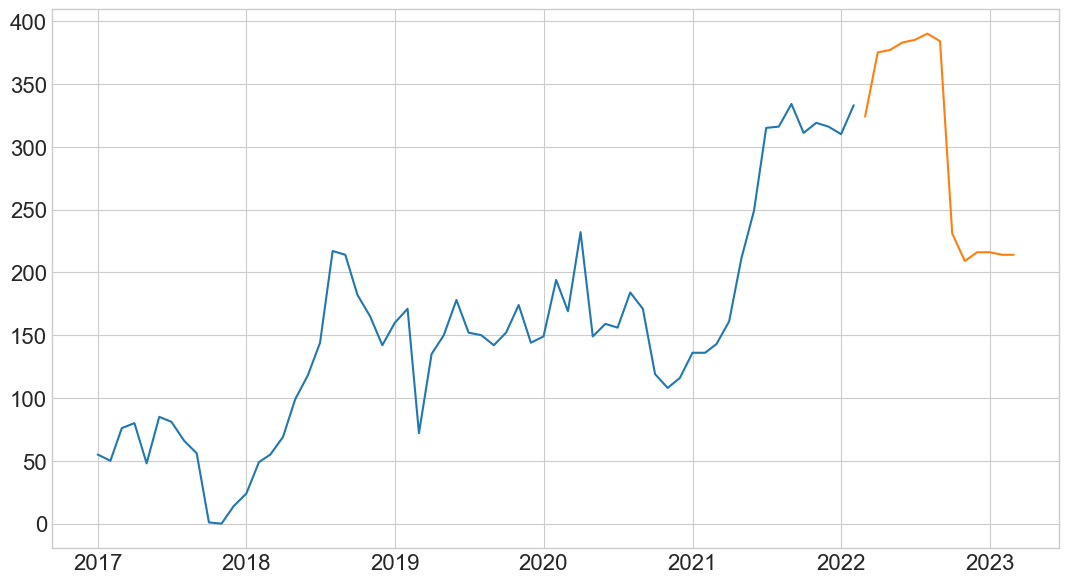

In [8]:
# plotted train, test difference:
plt.plot(train.index, train['diff'])
plt.plot(test.index, test['diff'])

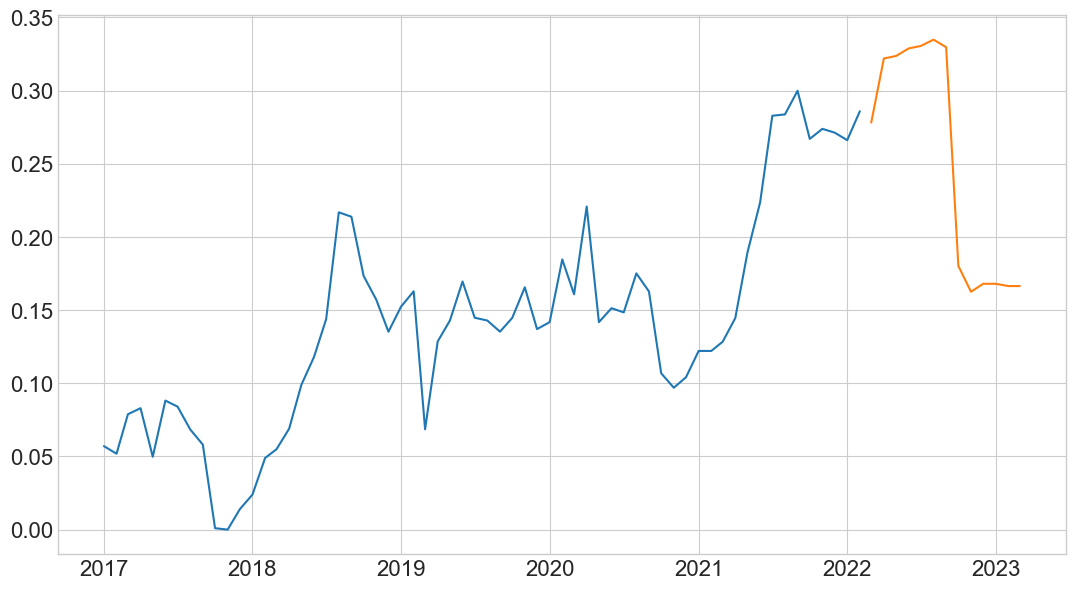

In [9]:
# plotted train, test percent diff in fmr terms:
plt.plot(train.index, train['percent_diff'])
plt.plot(test.index, test['percent_diff'])

The same overview of the data in pershows a widening gap between the FMR and the MMR with several periods of rapid change. Looks like the most common gap in this period is in the 150 to 200 dollar range.

In [13]:
# storing target as y for easy access
# y = train['diff']

# going to establish y as referring to the entire dataframe. For the sake of exploration
# in TSA, this seems more descriptive and should in no way poison a later modeling process
# which will use split data.
y = df['diff']
# also establishing y_p which refers to the percentage difference between the FMR and MMR
# in terms of FMR. This will better reflect how the rate are actually tracking one another.
y_p = df['percent_diff']

<AxesSubplot:ylabel='Frequency'>

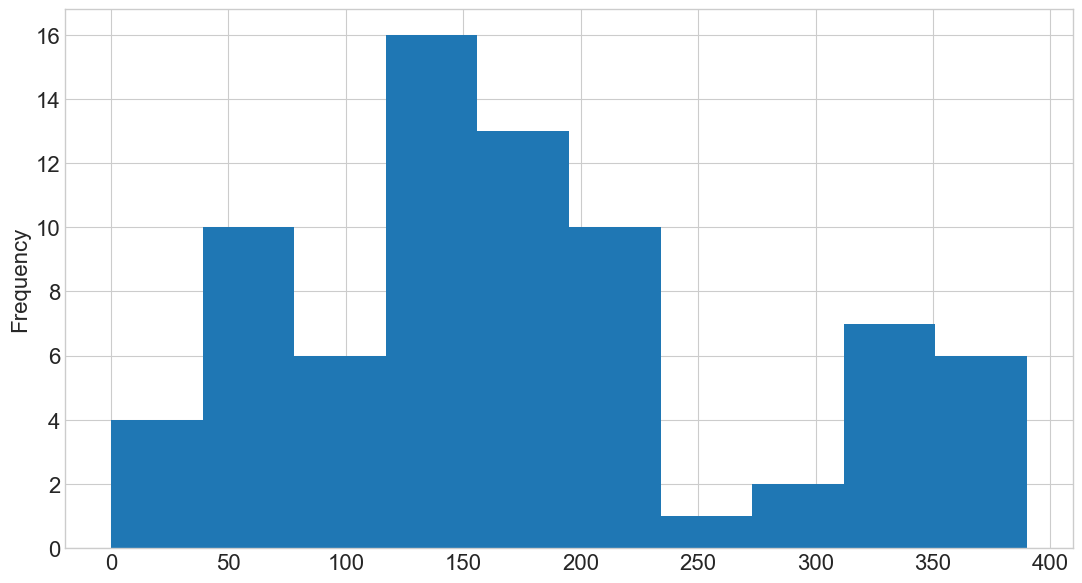

In [14]:
y.plot.hist()


In [1]:
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Difference Between Median Market Rate(MMR) \
and Fair Market Rate(FMR) by Month', xlabel='Month', ylabel='Difference between MMR and FMR')


NameError: name 'y' is not defined

In [16]:
y

2017-01-01     55.0
2017-02-01     50.0
2017-03-01     76.0
2017-04-01     80.0
2017-05-01     48.0
              ...  
2022-11-01    209.0
2022-12-01    216.0
2023-01-01    216.0
2023-02-01    214.0
2023-03-01    214.0
Name: diff, Length: 75, dtype: float64

<AxesSubplot:xlabel='month', ylabel='diff'>

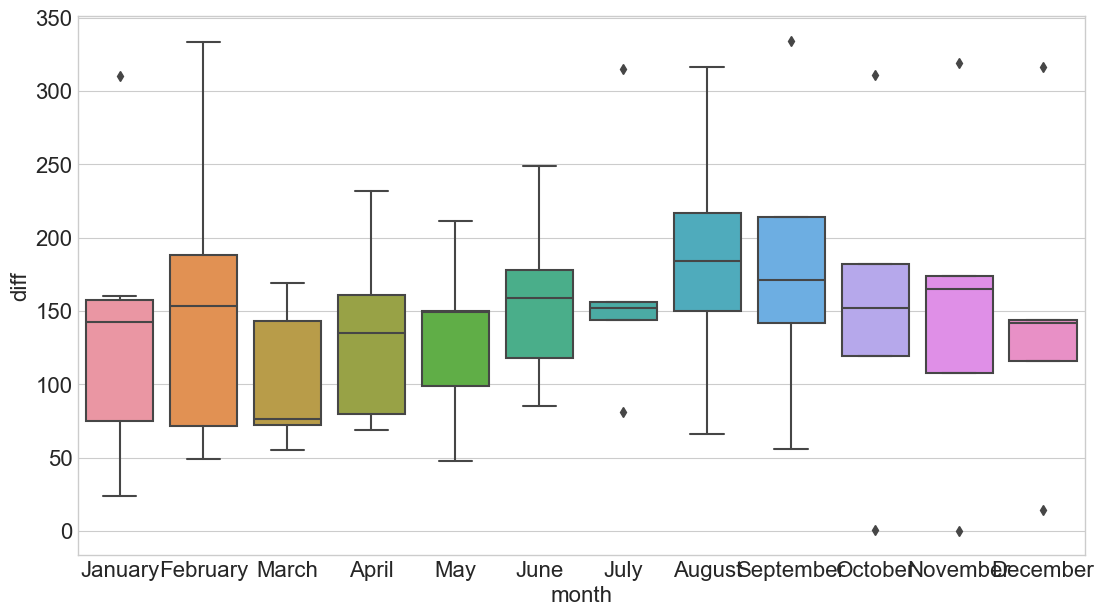

In [20]:
# establishing month
train['month'] = train.index.month_name()

# checking train
train

# box plot
sns.boxplot(data = train, x='month', y='diff')

These box plots show that the differences between the FMR and MMR tend to be greater toward the end of the fiscal year.

### Visualize the target over time

<AxesSubplot:>

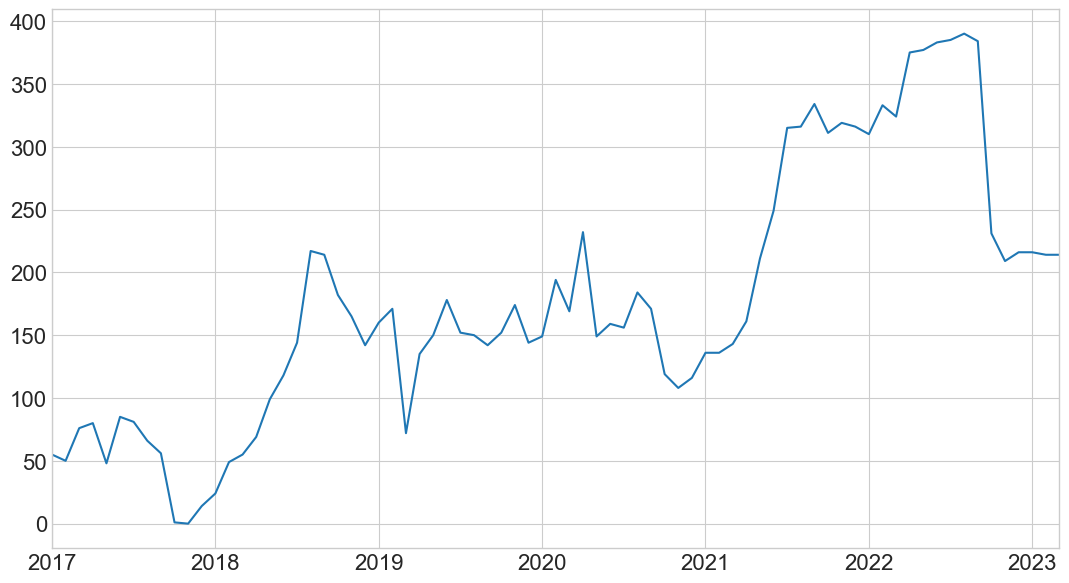

In [21]:
y.plot()


<AxesSubplot:title={'center':'2-year average percent change in difference'}>

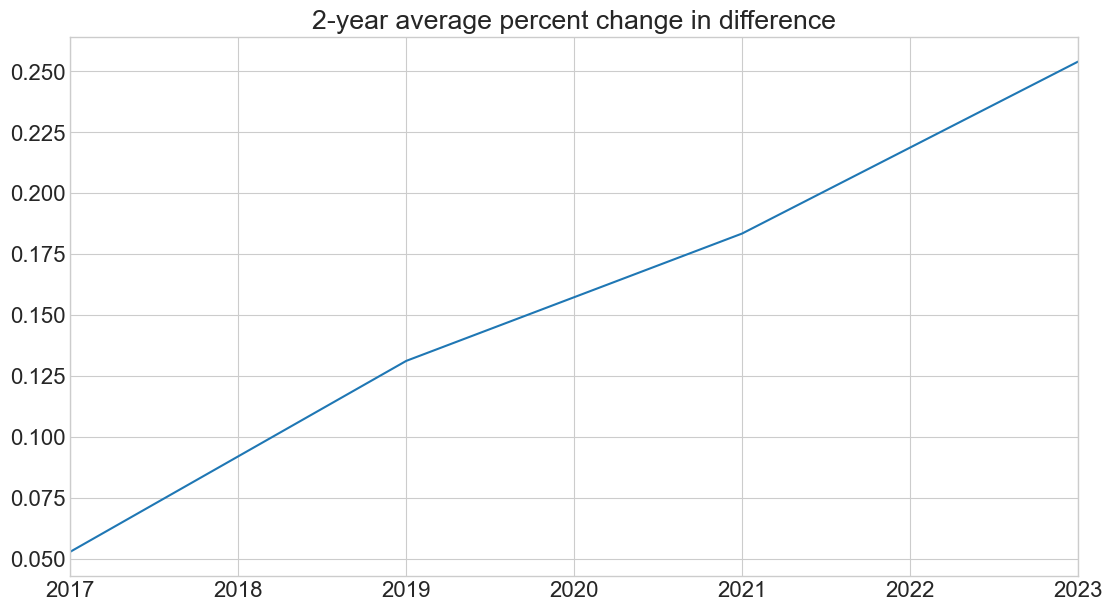

In [40]:
y_p.resample('2Y').mean().plot(title='2-year average percent change in difference')


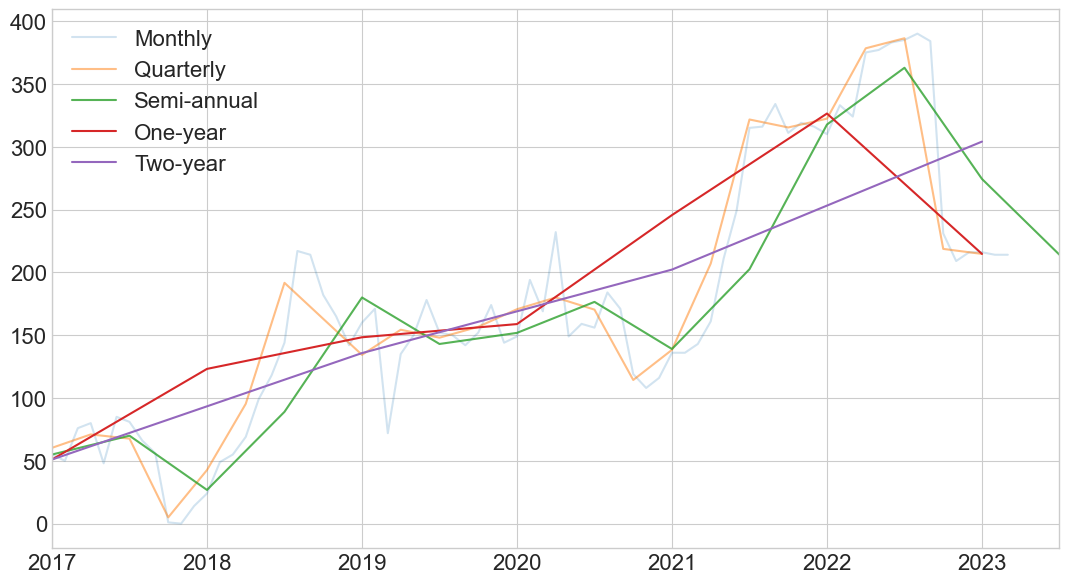

In [23]:
# Resampled Differences at 4 periodicities
y.plot(alpha=.2, label='Monthly')
y.resample('Q').mean().plot(alpha=.5, label='Quarterly')
y.resample('6M').mean().plot(alpha=.8, label='Semi-annual')
y.resample('Y').mean().plot(label='One-year')
y.resample('2Y').mean().plot(label='Two-year')
plt.legend()


### Visualize rolling averages over time

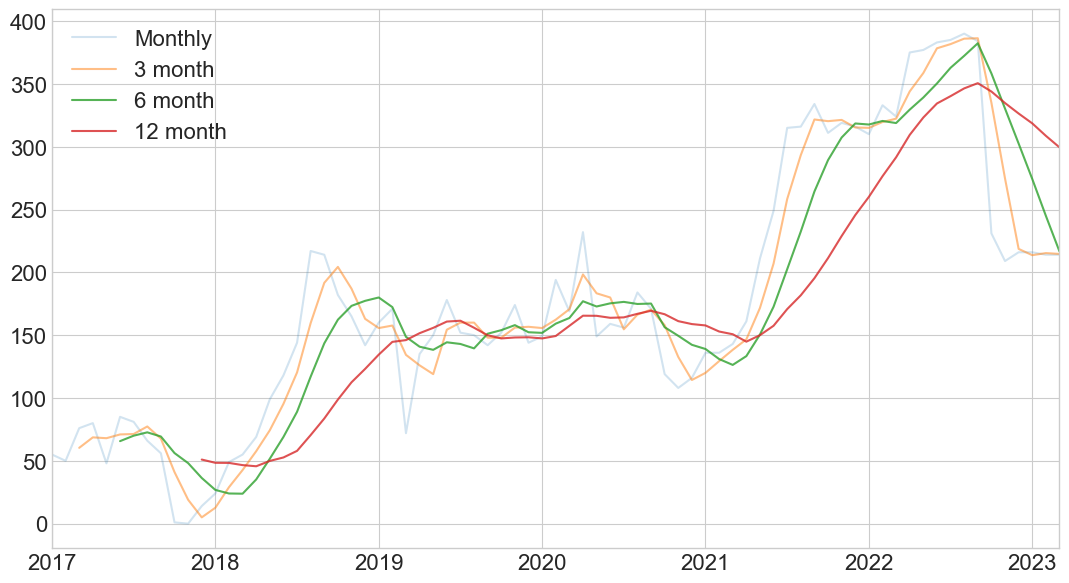

In [24]:
# Rolling Averages

y.plot(alpha=.2, label='Monthly')
y.rolling(3).mean().plot(alpha=.5, label='3 month')
y.rolling(6).mean().plot(alpha=.8, label='6 month')
y.rolling(12).mean().plot(alpha=.8, label='12 month')
plt.legend()


### Visualize change over time

<AxesSubplot:title={'center':'Average month-month change in Difference Between FMR/MMR'}>

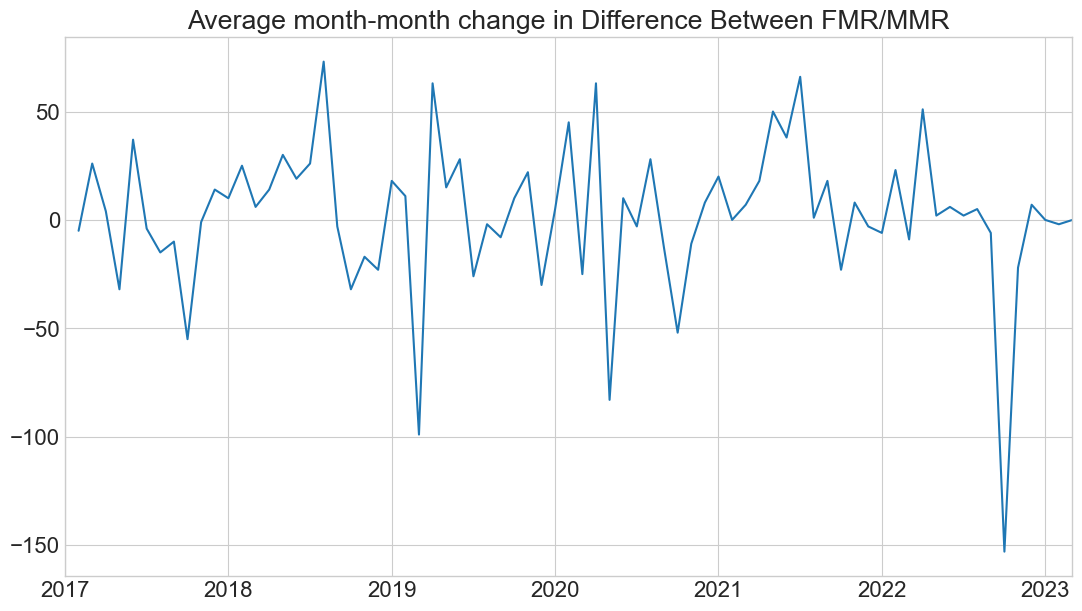

In [25]:
y.diff().plot(title='Average month-month change in Difference Between FMR/MMR')


### A Tale of Two Rates:

- HUD FMR Rate(fmr) is supposed to be the 40th percentile of market rates. It is adjusted once a year and goes into effect on October 1st, the start of the Federal fiscal year.
- Median Market Rate(mmr) is the median value of properties in the MSA (cannot verify that the boundaries exactly match the federal boundaries) based on rental data from biggerpockets.com
- HUD tracks data for properties from efficiency to 4 bedroom. For MVP analysis, we standardized to 2-bedroom properties.

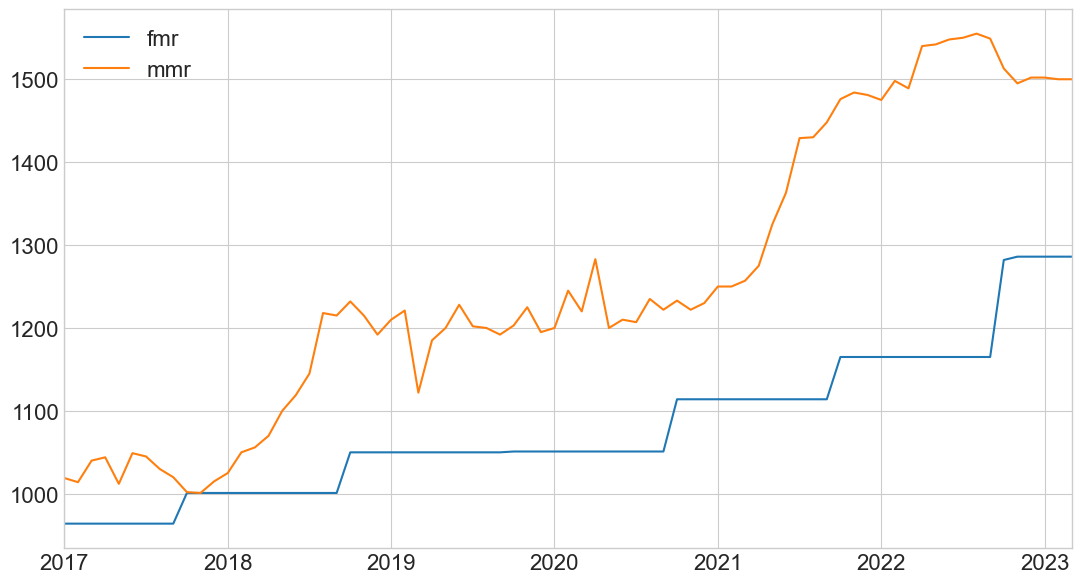

In [29]:
df.fmr.plot()
df.mmr.plot()
plt.legend()

### Seasonal Plots

<AxesSubplot:title={'center':'Annual Seasonal Plot of Percentage Differences Between MMR and FMR in Terms of FMR'}>

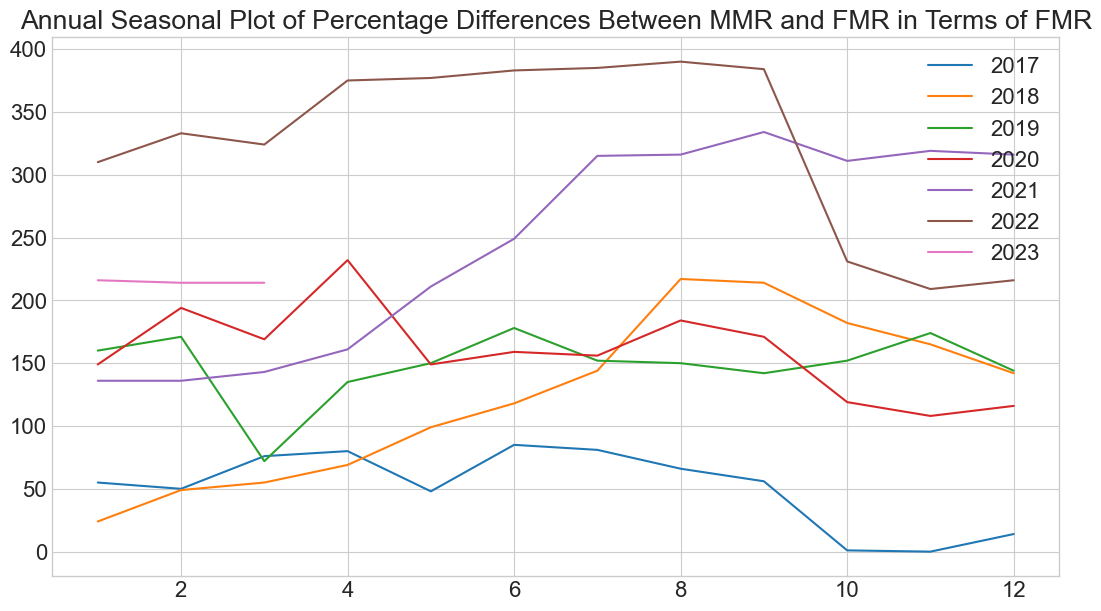

In [27]:
# .unstack turns an index level into columns
y.groupby([y_p.index.year, y_p.index.month]).mean().unstack(0).plot(title=
'Annual Seasonal Plot of Percentage Differences Between MMR and FMR in Terms of FMR')


### Seasonal Subseries Plot

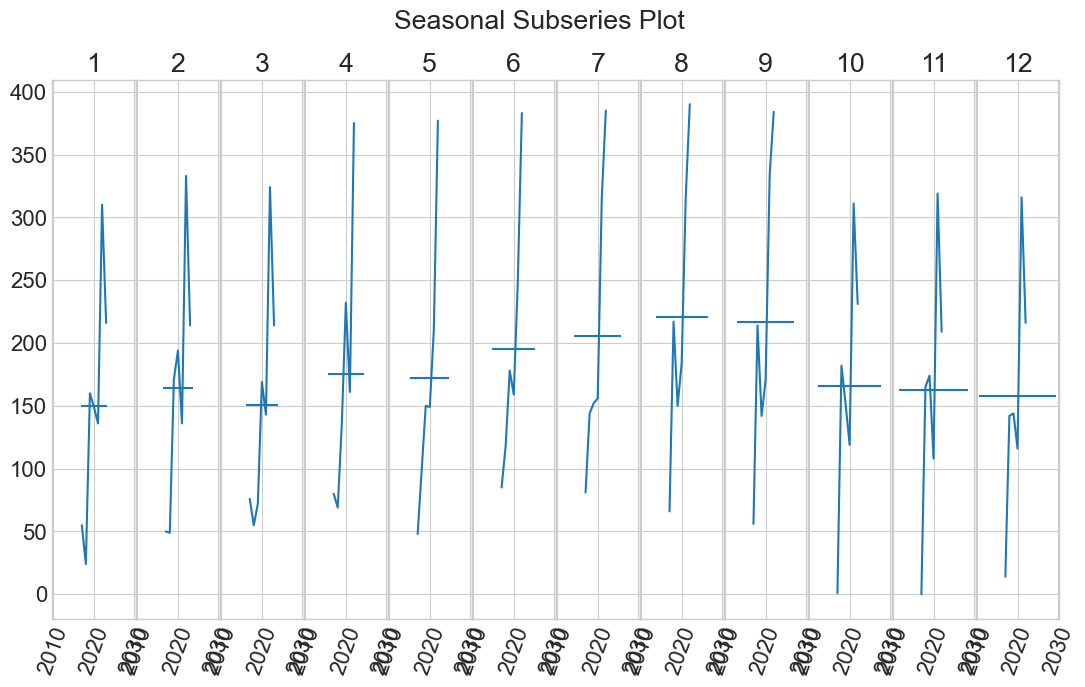

In [30]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack(0)

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iterrows()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim())
    ax.set(xlabel='')
    ax.set_xticklabels([int(thing) for thing in ax.get_xticks()], rotation = 70)

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)


### Autocorrelation Plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

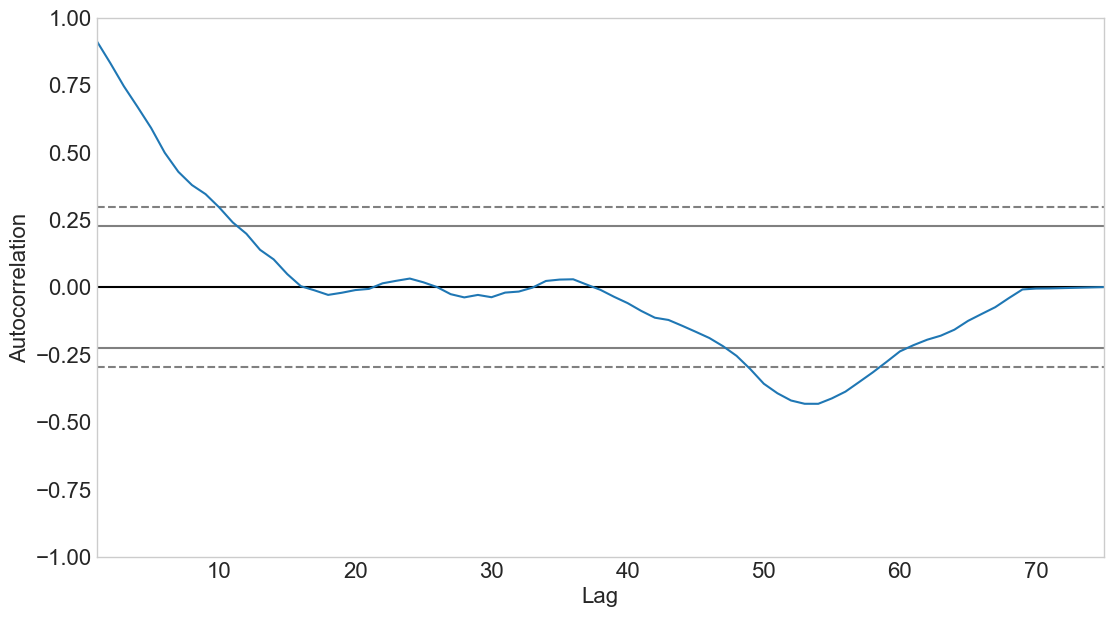

In [32]:
pd.plotting.autocorrelation_plot(df.percent_diff)


With little to no pattern and most of the lag periods falling between the middle bands, is seems there is little autocorrelation detected in this dataset.

### Seasonal Decomposition

In [37]:
y = df.percent_diff

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()


,y,trend,seasonal,resid
2017-01-01,0.057054,NaN,-0.022267,NaN
2017-02-01,0.051867,NaN,-0.006938,NaN
2017-03-01,0.078838,NaN,-0.034124,NaN
2017-04-01,0.082988,NaN,0.000893,NaN
2017-05-01,0.049793,NaN,0.000422,NaN


<AxesSubplot:>

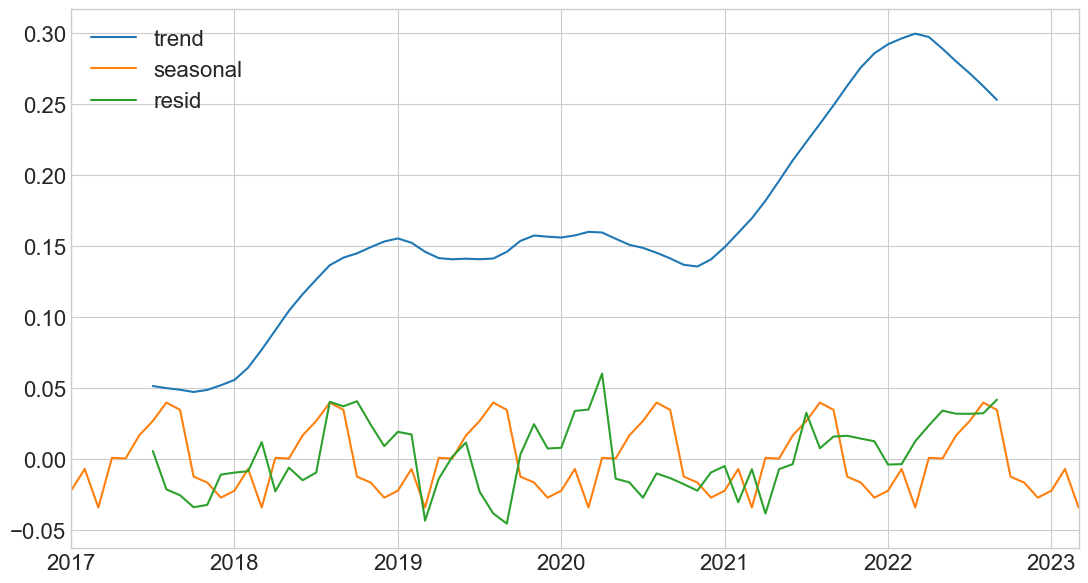

In [38]:
decomposition.iloc[:, 1:].plot()


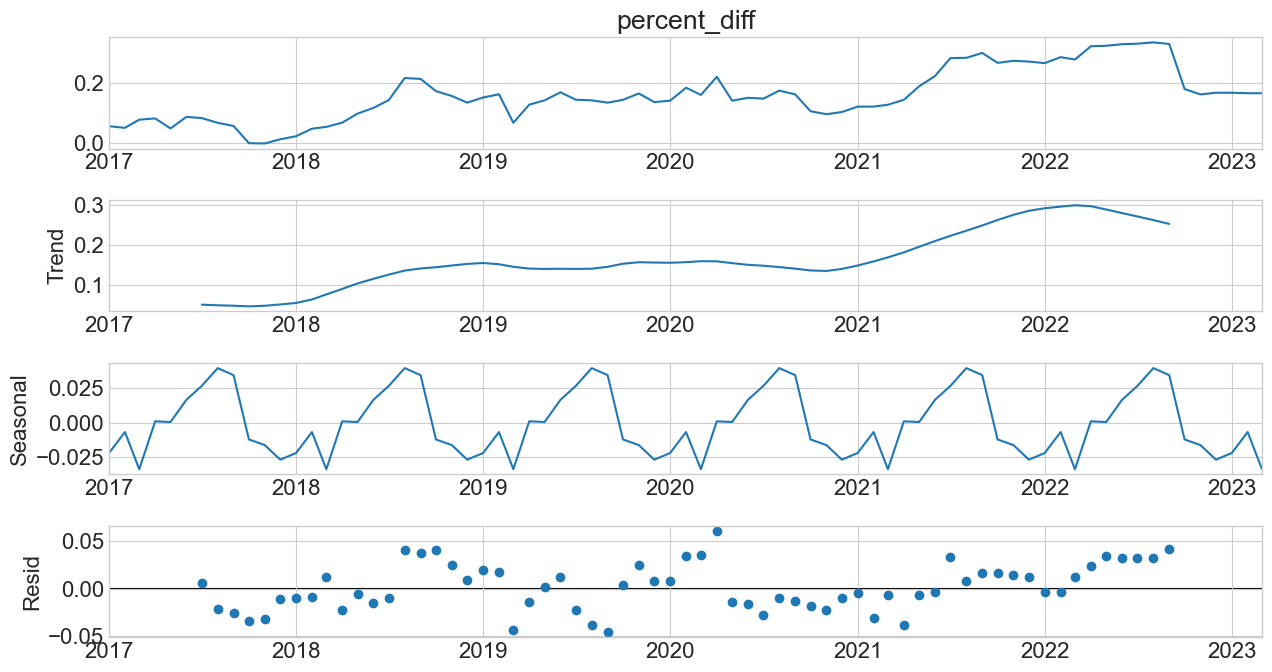

In [39]:
# the value returned from seasonal_decompose can itself be plotted:
result.plot()
None
